In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import random

In [3]:
spectrograms_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations'
metrics_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/metrics'

In [4]:
images = []
labels = []

fraction = 0.7

emotion_to_index = {
    "angry": 0,
    "happy": 1,
    "sad": 2,
    "neutral": 3,
    "fearful": 4,
    "disgust": 5,
    "surprise": 6,
}

all_files = [file for file in os.listdir(spectrograms_dir) if file.endswith(".png")]
selected_files = random.sample(all_files, int(len(all_files) * fraction))

for file_name in selected_files:
    file_path = os.path.join(spectrograms_dir, file_name)

    img = Image.open(file_path).convert("RGB")
    img = img.resize((256, 256))
    img_array = np.array(img)

    images.append(img_array)

    emotion = file_name.split("_")[1]
    label = emotion_to_index.get(emotion, -1)
    if label == -1:
        raise ValueError(f"Émotion inconnue dans le fichier : {file_name}")

    labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One-hot
num_classes = len(emotion_to_index)
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")

Ensemble d'entraînement : (1400, 256, 256, 3), (1400, 7)
Ensemble de validation : (300, 256, 256, 3), (300, 7)
Ensemble de test : (301, 256, 256, 3), (301, 7)


In [5]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Avoid overfitting

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (256, 256, 3)  # 3 channels (RGB)
model = create_cnn_model(input_shape, num_classes)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,879 (56.61 MB)

 Trainable params: 14,839,879 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.2026 - loss: 2.0432 - val_accuracy: 0.3167 - val_loss: 1.7680
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3596 - loss: 1.6469 - val_accuracy: 0.4933 - val_loss: 1.3831
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5191 - loss: 1.2681 - val_accuracy: 0.4867 - val_loss: 1.3005
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5951 - loss: 1.1304 - val_accuracy: 0.5367 - val_loss: 1.2442
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6370 - loss: 0.9621 - val_accuracy: 0.5400 - val_loss: 1.2584
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7148 - loss: 0.7812 - val_accuracy: 0.5433 - val_loss: 1.1884
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7740 - loss: 0.6365 - val_accuracy: 0.5400 - val_loss: 1.2287
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8227 - loss: 0.5120 - val_accuracy: 0.5767 -

In [7]:
model_name = "CNN"
model_metrics_dir = os.path.join(metrics_dir, model_name)
os.makedirs(model_metrics_dir, exist_ok=True)

In [8]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "accuracy_curve.png"))
plt.close()


In [12]:
emotion_labels = [
    "Angry", "Happy", "Sad", "Neutral", "Fearful", "Disgust", "Surprise"
]

# Prédictions et étiquettes vraies
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CNN on Spectrograms")

# Sauvegarde de la matrice de confusion
conf_matrix_path = os.path.join(model_metrics_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


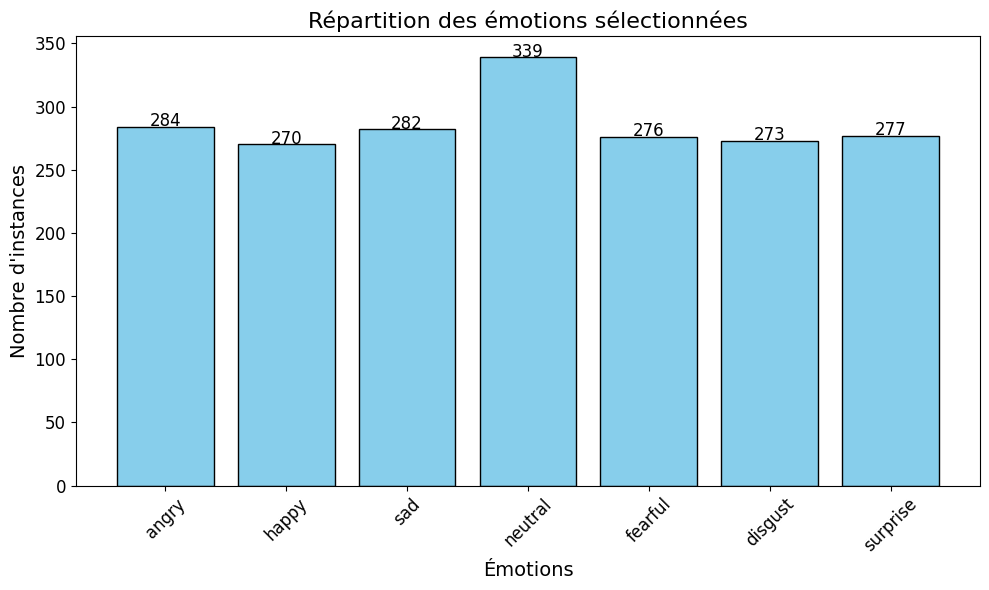

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Comptage des occurrences de chaque émotion
emotion_counts = {emotion: 0 for emotion in emotion_to_index.keys()}
for label in labels:
    # Récupérer le nom de l'émotion à partir de l'indice
    emotion_name = list(emotion_to_index.keys())[list(emotion_to_index.values()).index(label)]
    emotion_counts[emotion_name] += 1

# Création des données pour l'histogramme
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

# Affichage de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue', edgecolor='black')
plt.title("Répartition des émotions sélectionnées", fontsize=16)
plt.xlabel("Émotions", fontsize=14)
plt.ylabel("Nombre d'instances", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Ajout des valeurs au-dessus des barres
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()
